In [1]:
# pip install spacy
# python -m spacy download it_core_news_sm

import os
import re
import pandas as pd
from nltk.corpus import stopwords
import spacy
import math
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

### Utils

In [2]:
stop_words = set(stopwords.words('italian')) #remove stop words
lemmatizer = spacy.load('it_core_news_sm')

def pre_processing(document):
    document = re.sub(r'[^\w\s]',' ',document) #remove punctuation
    document = document.lower()
    document = lemmatizer(document)
    document = [token.lemma_ for token in document]
    document = [w for w in document if not w in stop_words]
    return document

#inverse document frequency
def idf(word, documents_list):
    return math.log10(len(documents_list)/sum([1.0 for i in documents_list if word in i.testo]))

#term frequency
def tf(word, document_words):
    return document_words.count(word)/len(document_words)

In [3]:
class Documento:
    # ============================================
    # Constructor
    # ============================================
    def __init__(self, titolo, classe, testo):
        self.titolo = titolo
        self.classe = classe
        self.testo = testo
        self.term_vector = []

    def __str__(self):
        return "Titolo: " + self.titolo + "\nClasse: " + self.classe

### Vector space model

In [4]:
path = "data\docs_200"
documents = []
classi = set()
vocabolario = set()

for file_name in os.listdir(path):
    if os.path.isfile(os.path.join(path, file_name)):
        file = open("data/docs_200/" + file_name, "r", encoding="utf-8")
        classe = file_name.split("_")[0]
        sentence = file.read().replace("\n", " ").replace("\"", "")
        sentence = pre_processing(sentence)
        sentence = sentence[:20]
        document = Documento(file_name, classe, sentence)
        vocabolario.update(document.testo)
        classi.add(file_name.split("_")[0])

        documents.append(document)        

In [6]:
for doc in documents:
    weights = {}
    for word in vocabolario:
        weights.update({word: tf(word, doc.testo) * idf(word, documents)})
    doc.term_vector = weights

In [7]:
colori = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "gray", "black"]

#foreach classe in classi assign a color
colors_list = {}
i = 0
for classe in classi:
    if classe not in colors_list.keys():
        colors_list[classe] = colori[i]
        i += 1 

print(colors_list['economia'])

green


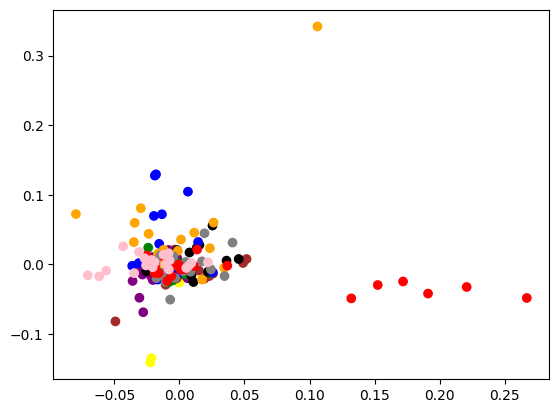

In [8]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#get all document term vectors and assign a color to each class
X = []
color_classes = []
for doc in documents:
    X.append(list(doc.term_vector.values()))
    color_classes.append(colors_list[doc.classe])

#convert to numpy array
X = np.array(X)

#apply PCA
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

#plot
plt.scatter(X_r[:, 0], X_r[:, 1], c=color_classes)
plt.show()

### Metodo di Rocchio

#### Calcolo dei prototipi (training)

In [9]:
class Prototipo:
    # ============================================
    # Constructor
    # ============================================
    def __init__(self, classe, profile_vector):
        self.classe = classe
        self.profile_vector = profile_vector

    def __str__(self):
        return "Classe: " + self.classe + "\nProfile vector: " + str(self.profile_vector)

In [10]:
def train(documents, classi, beta=4, gamma=16):
    prototipi = []
    for classe in classi:
        prototipi.append(prototipo_rocchio(classe, documents, beta, gamma))

    return prototipi

def prototipo_rocchio(classe, documents, beta, gamma):
    contributi_pos = {}
    contributi_near_pos = {}
    for word in vocabolario:
        contributi_pos.update({word: 0})
        contributi_near_pos.update({word: 0})

    near_pos = near_positive_documents(classe, documents)

    # contributo dei positivi
    count_pos = 0
    for doc in documents:
        if doc.classe == classe:
            for word in vocabolario:
                contributi_pos[word] += doc.term_vector[word]
            count_pos += 1
    for word in vocabolario:
        contributi_pos[word] /= count_pos


    # contributo dei near positive
    count_near_pos = 0
    for n_pos in near_pos:
        for word in vocabolario:
            contributi_near_pos[word] -= n_pos.term_vector[word]
        count_near_pos += 1

    for word in vocabolario:
        contributi_near_pos[word] /= count_near_pos

    # calcolo del prototipo
    prototipo = {}
    for word in vocabolario:
        prototipo[word] = beta * contributi_pos[word] - gamma * contributi_near_pos[word]

 
    return Prototipo(classe, prototipo)

#define method for calculating near_positve documents for rocchio methods
def near_positive_documents(classe_pos, documents):
    near_positive_documents = []
    for doc in documents:
        if doc.classe == classe_pos:
            near_positive_documents.append(get_nearest_doc(doc, documents))

    return near_positive_documents

# restituisce il documento più simile al documento positivo
def get_nearest_doc(positive_doc, documents):
    max_similarity = 0
    nearest_doc = None
    for doc in documents:
        if doc.classe != positive_doc.classe:
            positive_doc_s = np.array(list(positive_doc.term_vector.values())).reshape(1, -1)
            doc_s = np.array(list(doc.term_vector.values())).reshape(1, -1)
            similarity = cosine_similarity(positive_doc_s, doc_s)[0][0]
            if similarity > max_similarity:
                max_similarity = similarity
                nearest_doc = doc
    return nearest_doc
    

In [11]:
prototipo_sport = prototipo_rocchio("sport", documents, 16, 4)

##### cross-validation

In [12]:
def score_rocchio (prototipi, test_set):
    score = 0
    for doc in test_set:
        max_similarity = 0
        for prototipo in prototipi:
            doc_s = np.array(list(doc.term_vector.values())).reshape(1, -1)
            prototipo_s = np.array(list(prototipo.profile_vector.values())).reshape(1, -1)
            similarity = cosine_similarity(doc_s, prototipo_s)[0][0]
            if similarity > max_similarity:
                max_similarity = similarity
                classe = prototipo.classe
        if classe == doc.classe:
            score += 1
    return score/len(test_set)*100


def cross_val_score(documents, classi, cv=5, gamma=16, beta=4):
    scores = []

    #shuffle documents
    documents_permutato = np.random.permutation(documents)

    #divide x in cv parti
    data_folds = np.array_split(documents_permutato, cv)

    for i in range(cv):
        current_data_training_set = np.concatenate(data_folds[:i] + data_folds[i+1:], axis=0)
        current_data_test_set = data_folds[i]

        prototipi = train(current_data_training_set, classi, gamma, beta)
        score = score_rocchio(prototipi, current_data_test_set)
        print("Fold " + str(i) + ": " + str(score) + " %")

        scores.append(score)
    
    return scores

- Beta: Il parametro beta controlla l'effetto del termine medio della classe negativa sul calcolo del vettore rappresentativo della classe di riferimento. Un valore più grande di beta enfatizza maggiormente il termine medio della classe negativa, mentre un valore più piccolo lo enfatizza meno. La scelta di beta dipende dalla distribuzione dei dati e dalle preferenze specifiche dell'utente. In generale, valori compresi tra 0 e 1 sono comuni per beta.
- Gamma: Il parametro gamma influenza il calcolo del vettore rappresentativo della classe negativa. Un valore più grande di gamma riduce l'effetto dei documenti della classe negativa, mentre un valore più piccolo lo aumenta. La scelta di gamma dipende dalla distribuzione dei dati e dalle preferenze specifiche dell'utente. Valori compresi tra 0 e 1 sono comuni per gamma.

In [27]:
best_gamma = 0
best_beta = 0
best_accuracy = 0
for i in range(20):
    for j in range(20):
        print("Iterazione", str(i+1), str(j+1))
        accuracies = cross_val_score(documents, classi, cv=2, gamma=i+1, beta=j+1)
        print('\n')
        for accuracy in accuracies:
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_gamma = i+1
                best_beta = j+1

Iterazione 1 1


KeyboardInterrupt: 

#### visualizzazione grafica

In [17]:
prototipi = {}
for classe in classi:
    prototipi[classe] = prototipo_rocchio(classe, documents, 4, 16)

In [18]:
colori = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "gray", "black"]

#foreach classe in classi assign a color
colors_list_pr = {}
i = 0
for classe in classi:
    if classe not in colors_list_pr.keys():
        colors_list_pr[classe] = colori[i]
        i += 1 

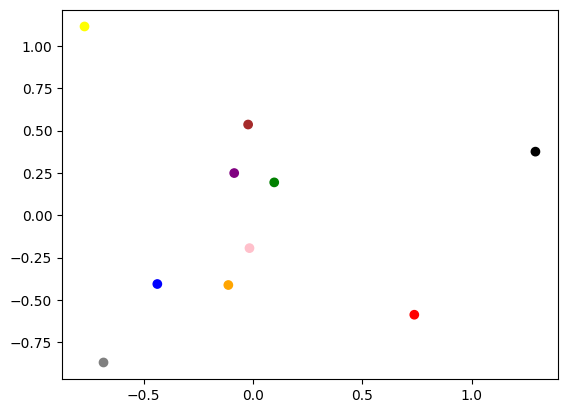

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = []
color_classes_pr = []
for classe in classi:
    X.append(list(prototipi[classe].profile_vector.values()))
    color_classes_pr.append(colors_list_pr[classe])

#convert to numpy array
X = np.array(X)

#apply PCA
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

#plot
plt.scatter(X_r[:, 0], X_r[:, 1], c=color_classes_pr)
plt.show()